In [1]:
from PIL import Image
from collections import OrderedDict

import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2
import random
from random import shuffle

import pydicom as dicomio
import nibabel as nib

import torch
import torch.utils.data

import torchvision
from torch.utils.data import Dataset
from torchsummary import summary
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch_lr_finder import LRFinder
import albumentations as A
import torchio as tio

print("Success")

/home/major/Major-Project-Experiments/venv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Success


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not available. Training on CPU ...")
else:
    print("CUDA is available. Training on GPU ...")

CUDA is available. Training on GPU ...


In [3]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


set_seed(51)

In [4]:
import nibabel as nib

def load_and_save_nifti(folder_path, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of all .nii.gz files in the folder
    s1 = [f for f in os.listdir(folder_path) if f.endswith(".nii.gz")]
    nifti_files = sorted(s1)

    # Create an empty 3D array
    # np_file = np.empty((0, 512, 512))
    # nifti_data_array = []
    for nifti_file in nifti_files:
        # Load NIfTI file
        nifti_path = os.path.join(folder_path, nifti_file)
        nii_img = nib.load(nifti_path)
        img_array = nii_img.get_fdata().astype(np.float16)
        ct_image = np.transpose(img_array, (2, 0, 1))
        print("Shape of the current CT:", ct_image.shape, " Count:", nifti_file)
        np.save(os.path.join(output_folder,nifti_file.replace(".nii.gz", ".npy")), ct_image)
        print(os.path.join(output_folder, nifti_file.replace(".nii.gz", ".npy")))

In [ ]:
if __name__ == "__main__":
    train_input_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr"
    train_output_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/train_np"
    load_and_save_nifti(train_input_folder, train_output_folder)

    mask_input_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/labelsTr"  # "/home/asadnabeel/NabeelWorkspace/PancreasDataset/labelsTr/mask_test/"
    mask_output_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/label_np"
    load_and_save_nifti(mask_input_folder, mask_output_folder)

    train_input_folder = "/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTs"
    train_output_folder = "/home/major/Major-Project-Experiments/data/organizedPancreasData/test_np"
    load_and_save_nifti(train_input_folder, train_output_folder)

In [5]:
import os

train_files = os.listdir("/home/major/Major-Project-Experiments/data/organizedPancreasData/train_np")
random.shuffle(train_files)
training_files = train_files[:210]
val_files = train_files[210:281]

test_files = os.listdir("/home/major/Major-Project-Experiments/data/organizedPancreasData/test_np")

In [6]:
# Display Slices from nii.gz.file
import numpy as np

# Load the NumPy array from the .npy file
tr_img = np.load("/home/major/Major-Project-Experiments/data/organizedPancreasData/train_np/pancreas_001_0000.npy")
mask_img = np.load("/home/major/Major-Project-Experiments/data/organizedPancreasData/label_np/pancreas_001.npy")

2.0


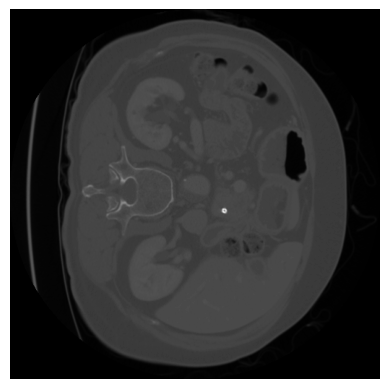

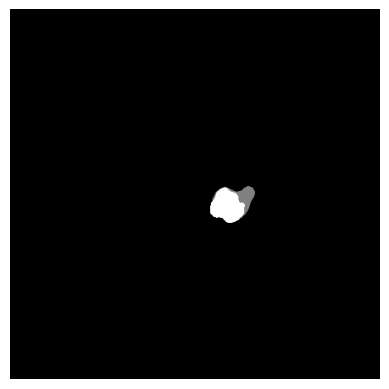

In [7]:
import matplotlib.pyplot as plt
slice_number = 45

image = tr_img[slice_number, :, :]
mask = mask_img[slice_number, :, :]
print(np.max(mask))

# Display the slice using matplotlib
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

# Display the slice using matplotlib
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

In [8]:
with open("/home/major/Major-Project-Experiments/data/organizedPancreasData/train.txt", 'w') as f:
    for filename in training_files:
        f.write(filename+'\n')

with open("/home/major/Major-Project-Experiments/data/organizedPancreasData/test.txt", 'w') as f:
    for filename in test_files:
        f.write(filename+'\n')

with open("/home/major/Major-Project-Experiments/data/organizedPancreasData/validation.txt", 'w') as f:
    for filename in val_files:
        f.write(filename+'\n')

In [2]:
import numpy as np

train_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/train.txt"
train_images = []
with open(train_txt) as file:
      for row in file:
        npy_file = row.strip('\n')
        npy_file = npy_file.replace('_0000.npy', '.npy')
        train_images.append(npy_file)

val_txt = "/home/major/Major-Project-Experiments/data/organizedPancreasData/validation.txt"
val_images = []
with open(val_txt) as file:
      for row in file:
        val_npy_file = row.strip('\n')
        val_npy_file = val_npy_file.replace('_0000.npy', '.npy')
        val_images.append(val_npy_file)

In [3]:
with open("/home/major/Major-Project-Experiments/data/organizedPancreasData/mask_train.txt", 'w') as f:
    for filename in train_images:
        f.write(filename+'\n')

with open("/home/major/Major-Project-Experiments/data/organizedPancreasData/mask_val.txt", 'w') as f:
    for filename in val_images:
        f.write(filename+'\n')

In [ ]:
# Clear all variables from the workspace
%reset -f

# Import the garbage collector module
import gc

# Collect garbage to free up memory
gc.collect()

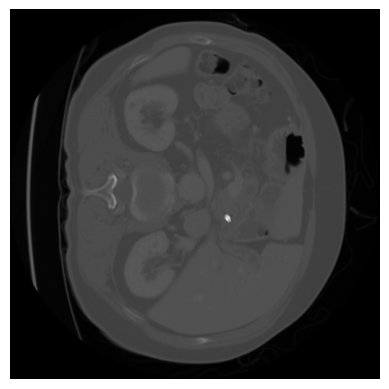

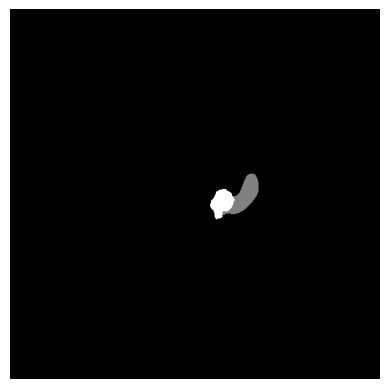

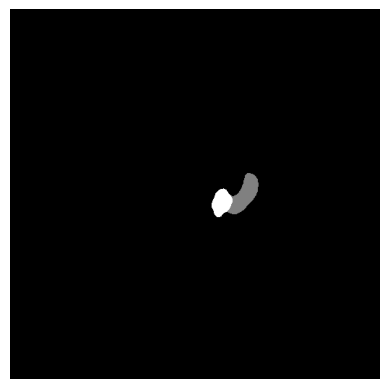

In [7]:
# Code to show the images
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

nii_img = nib.load("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/imagesTr/pancreas_001_0000.nii.gz")
img_array = nii_img.get_fdata().astype(np.float16)
ct_img = np.transpose(img_array, (2, 0, 1))

nii_label = nib.load("/home/major/Major-Project-Experiments/nnUNet_raw/Dataset007_Pancreas/labelsTr/pancreas_001.nii.gz")
label_array = nii_label.get_fdata().astype(np.float16)
ct_label = np.transpose(label_array, (2, 0, 1))

nii_pred = nib.load("/home/major/Major-Project-Experiments/poster_exp/output_1_3d_lowres/pancreas_001.nii.gz")
pred_array = nii_pred.get_fdata().astype(np.float16)
ct_pred = np.transpose(pred_array, (2, 0, 1))

plt.grid(False)
plt.axis('off')
plt.imshow(ct_img[50, :, :], cmap='gray')
plt.show()
plt.grid(False)
plt.axis('off')
plt.imshow(ct_label[50, :, :], cmap='gray')
plt.show()
plt.grid(False)
plt.axis('off')
plt.imshow(ct_pred[50, :, :], cmap = 'gray')
plt.show()
